In [26]:

from pyspark.sql import SparkSession
import math
import time
import matplotlib.pyplot as plt
import matplotlib.axes as Axes
import numpy


ss = SparkSession\
        .builder\
        .master("spark://localhost:7077") \
        .appName("LDSA14")\
        .getOrCreate()

sc = ss.sparkContext

In [6]:
import re

def wordMapper(x,line):
    length = len(line)
    if line.index(x) < length-1:
        return (x,(line[line.index(x) +1]))
    else:
        return (x,('ENDOFLINE'))

def to_list(a):
    return [a]

def append(a, b):
    a.append(b)
    return a

def extend(a, b):
    a.extend(b)
    return a

def countAverageLength(lines):
    lineLength = lines.map(lambda s: len(s))
    lineLength.persist()
    totalLength = lineLength.reduce(lambda a,b:a+b)
    totalLines = lines.count()
    return math.floor(totalLength/totalLines)

In [7]:
# Load text into RDD and cache.
#hdfs://localhost:9000/spark/
rootLines = sc.textFile('/home/ubuntu/Jupyter/emailBody.txt').cache()
rootLines = rootLines.repartition(100)
rootLines.count()
rootLines.getNumPartitions()


100

In [8]:

elapsedTime = []
for i in range(0, 3):

    startTime = time.time()

    # Remove leading/trailing whitespace, filter empty lines and lines starting with certain words or characters.
    toFilter = ("To:", "From:", "Subject:", "cc:", "Cc:", "CC:", "Sent:", "--", "__", "==")
    lines = rootLines.map(lambda x: x.strip()).filter(lambda x: not x.startswith(toFilter)).filter(lambda x: x != "")

    # Calcualte average length of a line.
    averageLength = countAverageLength(lines)

    # Split line into words and remove empty words.
    lines = lines.map(lambda x: x.split(" "))\
                .map(lambda x: [word.strip() for word in x if word.strip() != ""])

    # Compute word pairs in each line. This yields [[("dont",("know.")), ("know",("ENDOFLINE"))]]
    lines = lines.map(lambda line: [wordMapper(x,line) for x in line])

    # Collect by key. This yields [[("dont",("know."),("even.")), ("know",("ENDOFLINE"))]]
    words = lines.flatMap(lambda x: x).combineByKey(to_list, append, extend)\
                .sortByKey()

    #Find starting words ["Hej","Apple","Banana"]
    capitalWords = words.filter(lambda x: '' not in x).filter(lambda x: x[0][0].isupper()).sortByKey()

    elapsedTime.append(time.time() - startTime)
    print(elapsedTime)
print(elapsedTime)

[237.73357486724854]
[237.73357486724854, 237.10975456237793]
[237.73357486724854, 237.10975456237793, 224.55100750923157]
[237.73357486724854, 237.10975456237793, 224.55100750923157]


In [2]:
#1 core, 2Gb ram
twoWorkers_one = [776, 600, 656]

#2 cores, 2Gb ram
twoWorkers_two = [458, 346, 390]

#4 cores, 2Gb ram
twoWorkers_four = [300, 231, 280]

#6 cores, 2Gb ram
twoWorkers_six = [245, 230, 250]

#8 cores, 2Gb ram
twoWorkers_eight = [237, 237, 260]


In [3]:
arr = numpy.array([twoWorkers_one, twoWorkers_two, twoWorkers_four, twoWorkers_six, twoWorkers_eight])
mean = numpy.mean(arr, axis = 1)
print(arr)

[[776 600 656]
 [458 346 390]
 [300 231 280]
 [245 230 250]
 [237 237 260]]


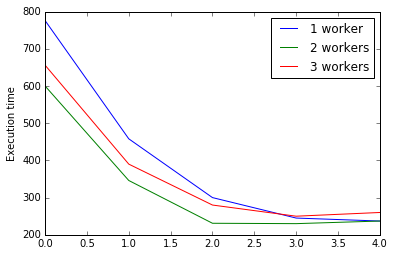

In [33]:
mpl_fig = plt.figure()

plt.plot(arr)
plt.ylabel('Execution time')
plt.legend( ('1 worker', '2 workers', '3 workers'))

plt.axis()
plt.axis('auto')

plt.show()


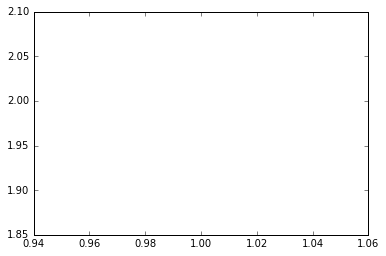

In [20]:
plt.plot([])

In [5]:
import random

plusminus = random.randrange(-10,11)
capitalWordDict = capitalWords.countByKey() #Create dictionary of all starting words
newEmail = []

firstWord = random.choice(list(capitalWordDict.keys()))
newEmail.append(firstWord)

previousWord = firstWord
while True: #Take random first word, then iterate from this word, taking random following word. If endofline is met, repeat.
    followingWord = random.choice(words.lookup(previousWord)[0])
    if followingWord != 'ENDOFLINE':
            newEmail.append(followingWord)
    else:
        if (averageLength + plusminus) <= len(newEmail):
            break
        followingWord = random.choice(list(capitalWordDict.keys()))
        newEmail.append("\n" + followingWord)
    previousWord = followingWord

email = ' '.join(newEmail)
print(email)

Stevinson Ranch is now reporting to get with this? If you this year's lunch next winter of t= 
Jayendran Rajamony 
Party/Dept. 
APEC process can send out of March'01 NP-15 (P, Next Week & COO Jan Johnson \(E-mail\)'" 
GEN_RPM numeric 
DISCLAIMER] 
IF-ELPO/SJ			IF-ELPO/SJ			GDP-ELPO/SJ			IF-ELPO/SJ 
AAB/AgAAgAIAAFABBgAYAP8AAAAAAAABDwAIAhAAUQEGABgA/wAAAAAAAAEPAAgCEABSAQYAGAD/


In [21]:
sc.stop()